In [1]:
import sys
sys.setrecursionlimit(5000)
%pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import matplotlib.pyplot as plt
%pip install scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
%pip install seaborn
import seaborn as sns
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2025-06-01 15:43:29.161257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Note: you may need to restart the kernel to use updated packages.


In [2]:
df              = pd.read_csv("data/final_merged_dispatch_with_registration.csv")
childersWeather = pd.read_csv("data/CHILDSF1.csv", parse_dates=['time'])
mewfWeather     = pd.read_csv("data/MEWF1.csv", parse_dates=['time'])

/var/folders/8s/d11q1jnd4p550kkfm8gcqcz80000gn/T/ipykernel_14753/2848658825.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df              = pd.read_csv("data/final_merged_dispatch_with_registration.csv")


In [3]:
# Convert from Australia/Sydney to Australia/Brisbane (UTC+10 year-round)
for weather_df in [childersWeather, mewfWeather]:
    weather_df['time'] = weather_df['time'].dt.tz_localize('Australia/Sydney', ambiguous='NaT', nonexistent='shift_forward')
    weather_df['time'] = weather_df['time'].dt.tz_convert('Australia/Brisbane').dt.tz_localize(None)

In [4]:
# Drop rows where Region is NaN
df = df[df['Region'].notna()]

df.reset_index(drop=True, inplace=True)

print(f"Cleaned df now has {len(df)} rows (Region not missing).")


Cleaned df now has 10139828 rows (Region not missing).


In [5]:
df = df[df['Region'] == 'QLD1'].reset_index(drop=True)

print(f"Filtered df now has {len(df)} rows (Region == 'QLD1').")


Filtered df now has 10139828 rows (Region == 'QLD1').


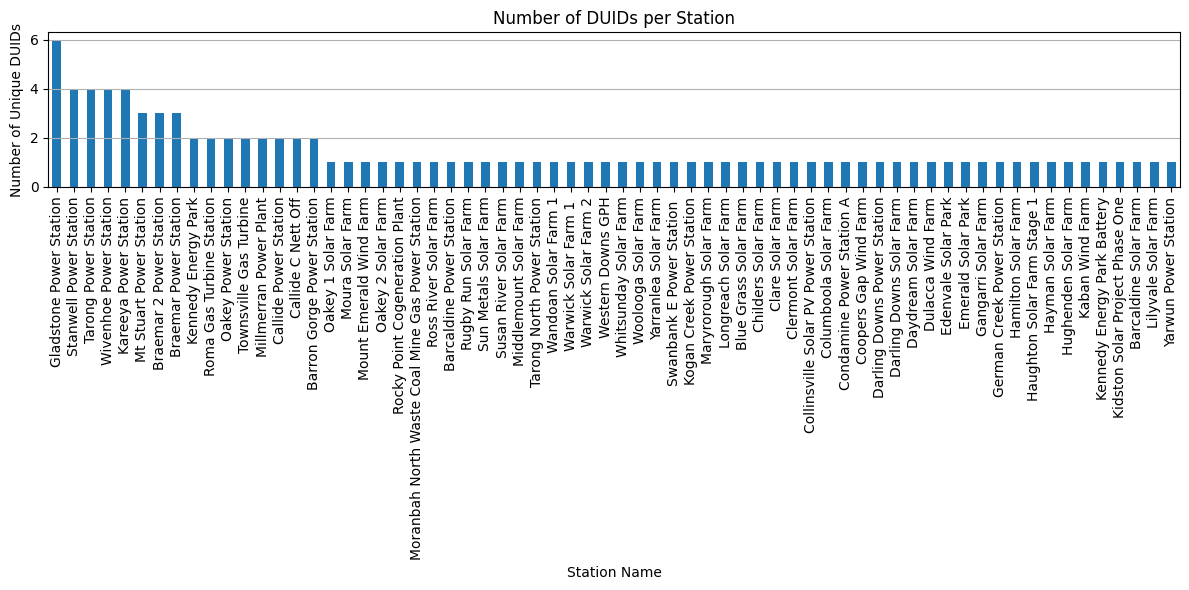

In [6]:
# Group by Station Name and count unique DUIDs
duidCounts = df.groupby('Station Name')['DUID'].nunique().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
duidCounts.plot(kind='bar')
plt.title('Number of DUIDs per Station')
plt.xlabel('Station Name')
plt.ylabel('Number of Unique DUIDs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [7]:
coordMap = {
    'Barcaldine Solar Farm': (-23.5477, 145.3189),
    'German Creek Power Station': (-22.9307, 148.5586),
    'Hughenden Solar Farm': (-20.8750, 144.1701),
    'Kennedy Energy Park Battery': (-20.8750, 144.1701),
    'Longreach Solar Farm': (-22.1647, 144.5845),
    'Moranbah North Waste Coal Mine Gas Power Station': (-22.0038, 148.0291),
    'Rocky Point Cogeneration Plant': (-27.7378, 153.3261),
    'Barcaldine Power Station': (-23.5522, 145.3143),
    'Barron Gorge Power Station': (-16.8508, 145.6467),
    'Blue Grass Solar Farm': (-26.6864, 150.4972),
    'Braemar Power Station': (-27.1109, 150.9053),
    'Braemar 2 Power Station': (-27.1128, 150.9049),
    'Callide Power Station': (-24.3463, 150.6186),
    'Childers Solar Farm': (-24.9227, 152.3420),
    'Clare Solar Farm': (-19.8398, 147.2106),
    'Clermont Solar Farm': (-22.8200, 147.6400),
    'Columboola Solar Farm': (-26.6500, 150.7500),
    'Coopers Gap Wind Farm': (-26.8500, 151.8500),
    'Callide C Nett Off': (-24.3463, 150.6186),
    'Condamine Power Station A': (-27.0500, 150.0500),
    'Collinsville Solar PV Power Station': (-20.5500, 147.8500),
    'Daydream Solar Farm': (-20.5500, 147.8500),
    'Darling Downs Power Station': (-27.0500, 150.0500),
    'Darling Downs Solar Farm': (-27.0500, 150.0500),
    'Edenvale Solar Park': (-27.0500, 150.0500),
    'Emerald Solar Park': (-23.5000, 148.1500),
    'Gangarri Solar Farm': (-27.0500, 150.0500),
    'Gladstone Power Station': (-23.8500, 151.2500),
    'Hamilton Solar Farm': (-20.5500, 147.8500),
    'Haughton Solar Farm Stage 1': (-19.6000, 147.0000),
    'Hayman Solar Farm': (-20.5500, 147.8500),
    'Kaban Wind Farm': (-17.6101, 145.3586),
    'Kareeya Power Station': (-17.7500, 145.6000),
    'Kennedy Energy Park': (-20.8750, 144.1701),
    'Kogan Creek Power Station': (-27.2500, 150.7500),
    'Kidston Solar Project Phase One': (-18.7500, 144.0000),
    'Lilyvale Solar Farm': (-23.5000, 148.1500),
    'Maryrorough Solar Farm': (-25.5000, 152.7000),
    'Mount Emerald Wind Farm': (-17.5000, 145.5000),
    'Middlemount Solar Farm': (-22.8000, 148.7000),
    'Moura Solar Farm': (-24.6000, 150.0000),
    'Millmerran Power Plant': (-27.9000, 151.3000),
    'Mt Stuart Power Station': (-19.2500, 146.8000),
    'Oakey Power Station': (-27.4000, 151.7000),
    'Oakey 1 Solar Farm': (-27.4000, 151.7000),
    'Oakey 2 Solar Farm': (-27.4000, 151.7000),
    'Wivenhoe Power Station': (-27.4000, 152.5000),
    'Roma Gas Turbine Station': (-26.5500, 148.8000),
    'Ross River Solar Farm': (-19.2500, 146.8000),
    'Rugby Run Solar Farm': (-22.8000, 147.6000),
    'Sun Metals Solar Farm': (-19.2500, 146.8000),
    'Susan River Solar Farm': (-25.5000, 152.7000),
    'Stanwell Power Station': (-23.5000, 150.5000),
    'Swanbank E Power Station': (-27.6500, 152.8500),
    'Tarong Power Station': (-26.7000, 151.9000),
    'Tarong North Power Station': (-26.7000, 151.9000),
    'Warwick Solar Farm 1': (-28.2000, 152.0000),
    'Warwick Solar Farm 2': (-28.2000, 152.0000),
    'Western Downs GPH': (-27.0000, 150.0000),
    'Whitsunday Solar Farm': (-20.5500, 147.8500),
    'Woolooga Solar Farm': (-26.0000, 152.5000),
    'Townsville Gas Turbine': (-19.2500, 146.8000),
    'Yarranlea Solar Farm': (-27.7000, 151.7000),
    'Yarwun Power Station': (-23.8000, 151.2000),
    'Wandoan Solar Farm 1': (-26.1000, 149.9500),
    'Dulacca Wind Farm': (-26.6000, 149.9000)
}


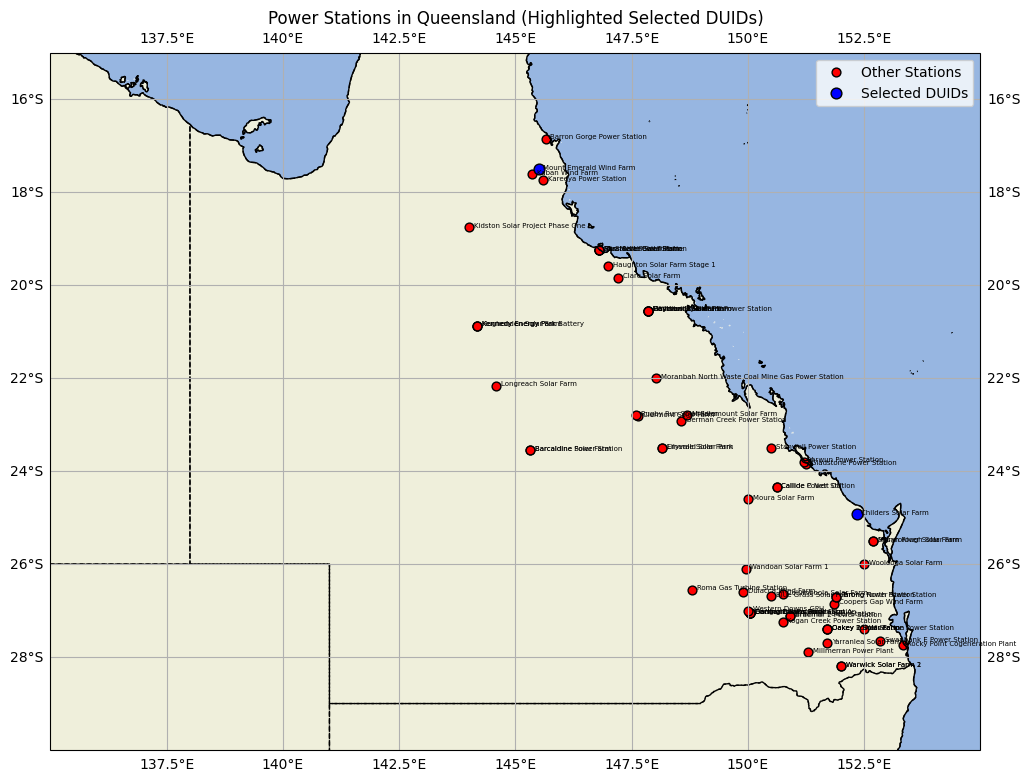

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Target stations to highlight
highlightStations = {
    'Childers Solar Farm': (-24.9227, 152.3420),
    'Mount Emerald Wind Farm': (-17.5000, 145.5000)
}

# Separate highlighted and regular stations
regularStations = {k: v for k, v in coordMap.items() if k not in highlightStations}

# Extract coordinates
highlightNames = list(highlightStations.keys()) 
highlightLats = [highlightStations[name][0] for name in highlightNames]
highlightLons = [highlightStations[name][1] for name in highlightNames]

regularNames = list(regularStations.keys())
regularLats = [regularStations[name][0] for name in regularNames]
regularLons = [regularStations[name][1] for name in regularNames]

# Set up the map
plt.figure(figsize=(12, 14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([135, 155, -30, -15])  # Focus on Queensland

# Add base map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')
ax.gridlines(draw_labels=True)

# Plot all regular stations in red
ax.scatter(regularLons, regularLats, color='red', s=40, edgecolor='k', label='Other Stations', transform=ccrs.PlateCarree())

# Highlight selected DUIDs in blue
ax.scatter(highlightLons, highlightLats, color='blue', s=60, edgecolor='black', label='Selected DUIDs', transform=ccrs.PlateCarree())

# Annotate all station names
for name, lat, lon in zip(regularNames + highlightNames, regularLats + highlightLats, regularLons + highlightLons):
    ax.text(lon + 0.1, lat, name, fontsize=5, transform=ccrs.PlateCarree())

plt.title("Power Stations in Queensland (Highlighted Selected DUIDs)")
plt.legend()
plt.show()


aggregate into 1h interval

In [9]:
# Ensure SCADAVALUE is numeric
df['SCADAVALUE'] = pd.to_numeric(df['SCADAVALUE'], errors='coerce')

df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
df.set_index('SETTLEMENTDATE', inplace=True)
# Now group by DUID and resample on the datetime index
df_h1 = df.groupby('DUID').resample('1H')['SCADAVALUE'].mean().reset_index()


/var/folders/8s/d11q1jnd4p550kkfm8gcqcz80000gn/T/ipykernel_14753/966245199.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_h1 = df.groupby('DUID').resample('1H')['SCADAVALUE'].mean().reset_index()


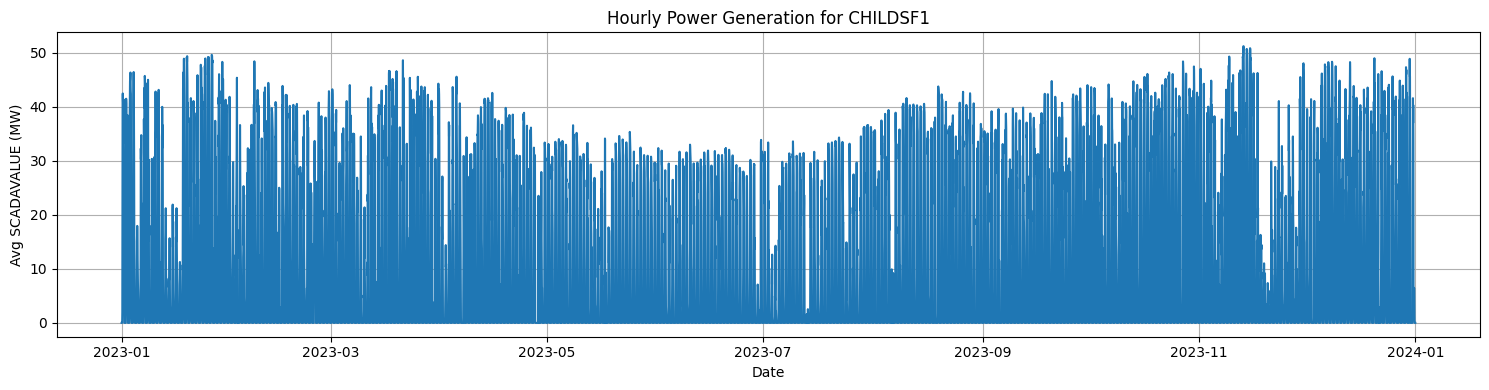

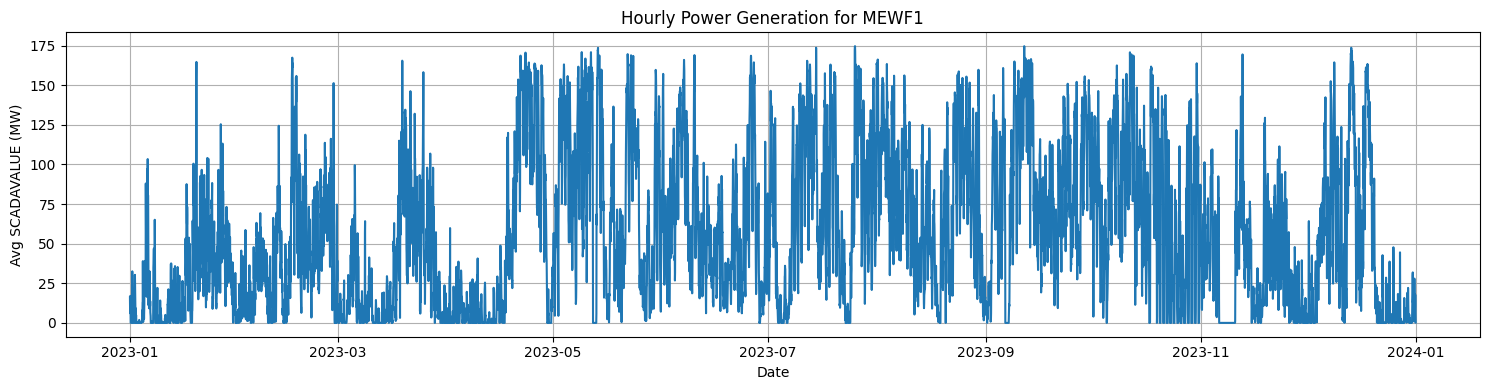

In [10]:
duid_list = ['CHILDSF1','MEWF1']

# Plot each DUID separately
for duid in duid_list:
    duid_data = df_h1[df_h1['DUID'] == duid]

    plt.figure(figsize=(15, 4))
    plt.plot(duid_data['SETTLEMENTDATE'], duid_data['SCADAVALUE'], color='tab:blue')
    plt.title(f"Hourly Power Generation for {duid}")
    plt.xlabel("Date")
    plt.ylabel("Avg SCADAVALUE (MW)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


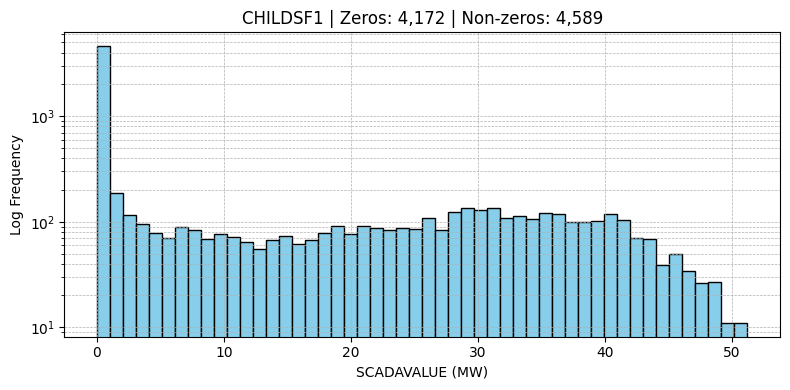

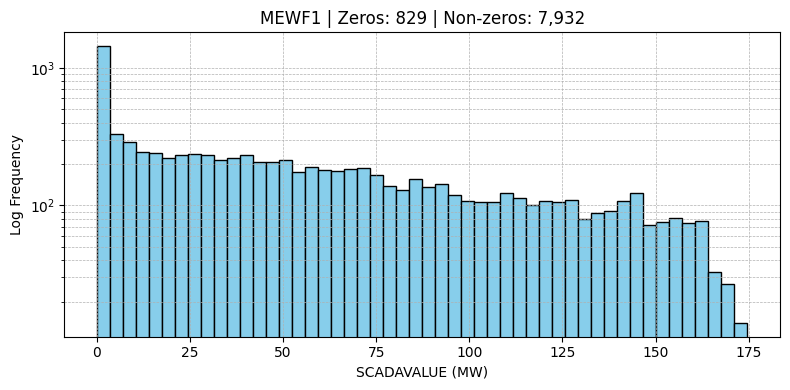

In [11]:
duid_list = ['CHILDSF1','MEWF1']

for duid in duid_list:
    duid_data = df_h1[df_h1['DUID'] == duid]
    
    # Count zeros and non-zeros
    num_zeros = (duid_data['SCADAVALUE'] == 0).sum()
    num_nonzeros = (duid_data['SCADAVALUE'] != 0).sum()

    # Plot
    plt.figure(figsize=(8, 4))
    plt.hist(duid_data['SCADAVALUE'], bins=50, color='skyblue', edgecolor='black')
    plt.yscale('log')
    
    plt.title(f"{duid} | Zeros: {num_zeros:,} | Non-zeros: {num_nonzeros:,}")
    plt.xlabel("SCADAVALUE (MW)")
    plt.ylabel("Log Frequency")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()




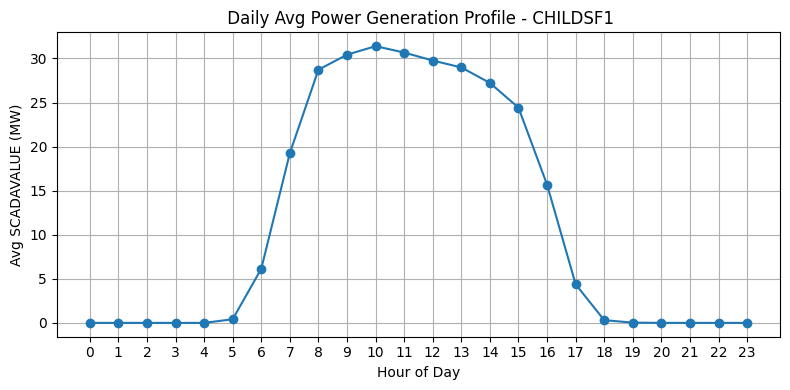

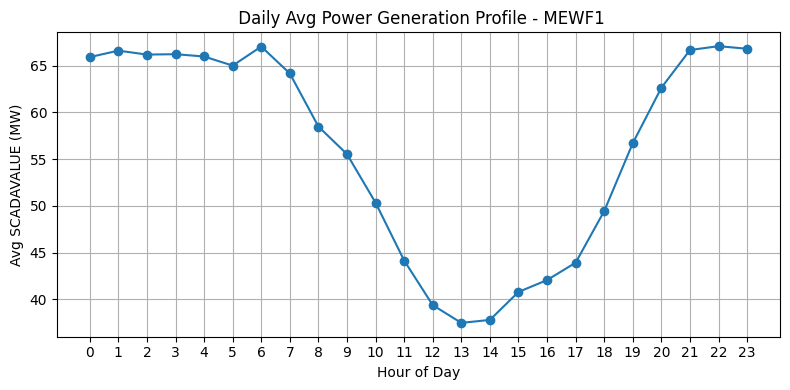

In [12]:
# Filter to only include the two DUIDs
filtered_df = df_h1[df_h1['DUID'].isin(duid_list)].copy()
# Extract hour from the timestamp
filtered_df['hour'] = filtered_df['SETTLEMENTDATE'].dt.hour
# Compute average SCADAVALUE per hour for each DUID
daily_avg = filtered_df.groupby(['DUID', 'hour'])['SCADAVALUE'].mean().reset_index()
# Plot daily average for each DUID
for duid in duid_list:
    duid_data = daily_avg[daily_avg['DUID'] == duid]

    plt.figure(figsize=(8, 4))
    plt.plot(duid_data['hour'], duid_data['SCADAVALUE'], marker='o')
    plt.title(f" Daily Avg Power Generation Profile - {duid}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Avg SCADAVALUE (MW)")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()



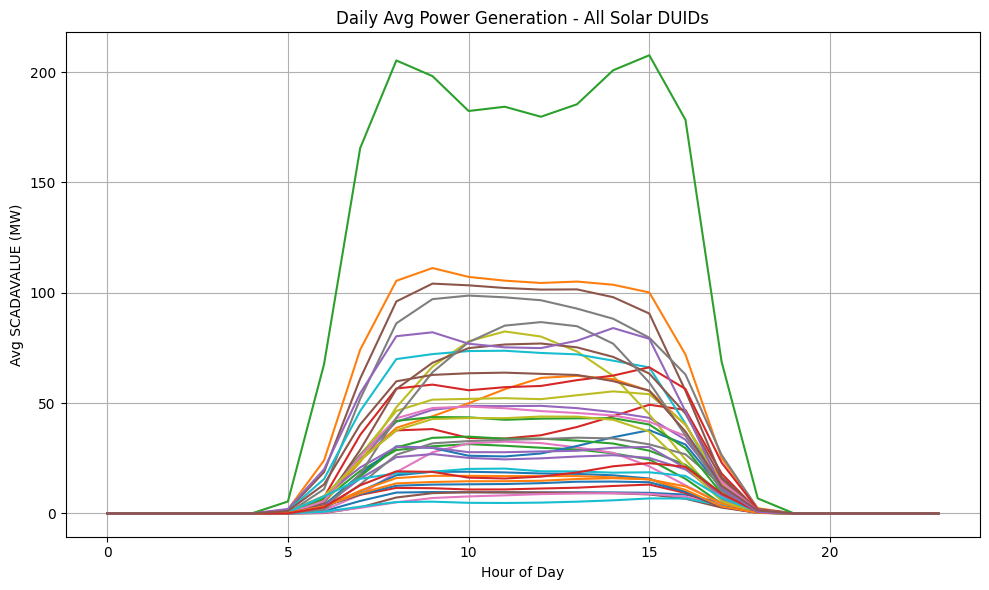

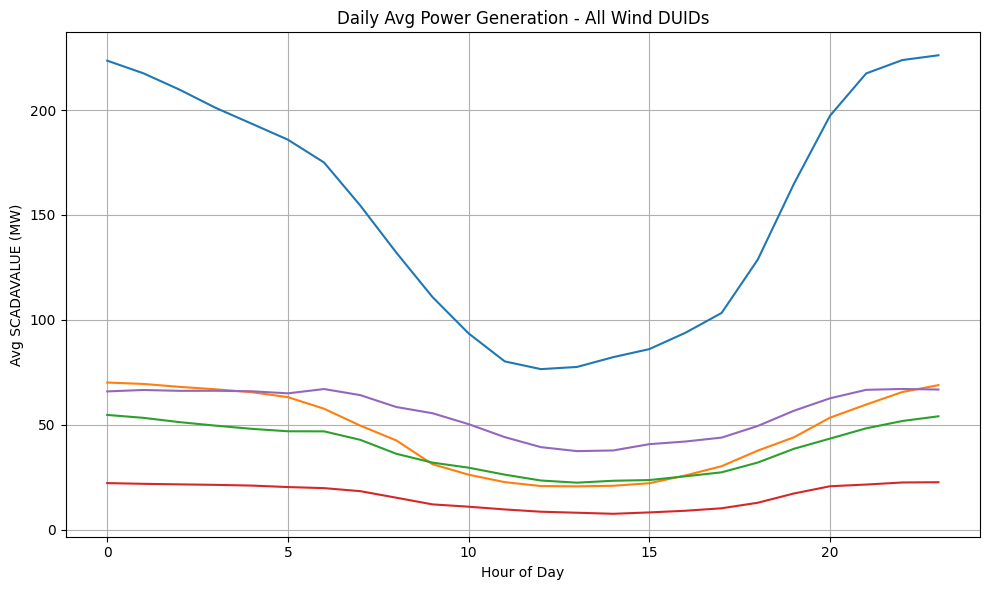

In [13]:
# Ensure 'hour' column exists
df_h1['hour'] = df_h1['SETTLEMENTDATE'].dt.hour
# Get solar and wind DUIDs
solar_df = df_h1[df_h1['DUID'].isin(df[df['Fuel Source - Primary'] == 'Solar']['DUID'].unique())]
wind_df = df_h1[df_h1['DUID'].isin(df[df['Fuel Source - Primary'] == 'Wind']['DUID'].unique())]
# Daily average by hour for solar
solar_avg = solar_df.groupby(['DUID', 'hour'])['SCADAVALUE'].mean().reset_index()
# Plot all solar generators
plt.figure(figsize=(10, 6))
for duid in solar_avg['DUID'].unique():
    duid_data = solar_avg[solar_avg['DUID'] == duid]
    plt.plot(duid_data['hour'], duid_data['SCADAVALUE'], label=duid)
plt.title("Daily Avg Power Generation - All Solar DUIDs")
plt.xlabel("Hour of Day")
plt.ylabel("Avg SCADAVALUE (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Daily average by hour for wind
wind_avg = wind_df.groupby(['DUID', 'hour'])['SCADAVALUE'].mean().reset_index()

# Plot all wind generators
plt.figure(figsize=(10, 6))
for duid in wind_avg['DUID'].unique():
    duid_data = wind_avg[wind_avg['DUID'] == duid]
    plt.plot(duid_data['hour'], duid_data['SCADAVALUE'], label=duid)
plt.title("Daily Avg Power Generation - All Wind DUIDs")
plt.xlabel("Hour of Day")
plt.ylabel("Avg SCADAVALUE (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Model implementations

filter the dataset only for our two DUIDs of intrest

In [14]:
duid_list = ['CHILDSF1', 'MEWF1']

# Filter the dataset
filtered_df = df_h1[df_h1['DUID'].isin(duid_list)].copy()


adding more variables

In [15]:
filtered_df['SETTLEMENTDATE'] = pd.to_datetime(filtered_df['SETTLEMENTDATE'])
filtered_df.set_index('SETTLEMENTDATE', inplace=True)

# Time-based features
filtered_df['hour'] = filtered_df.index.hour
filtered_df['dayofweek'] = filtered_df.index.dayofweek
filtered_df['is_weekend'] = filtered_df['dayofweek'].isin([5, 6]).astype(int)
filtered_df['month'] = filtered_df.index.month

# Define season from month
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

filtered_df['season'] = filtered_df['month'].apply(assign_season)

# Lag and rolling features — group by DUID to avoid data leakage
filtered_df['prev_hour_value'] = (
    filtered_df.groupby('DUID')['SCADAVALUE'].shift(1)
)

filtered_df['rolling_mean_24h'] = (
    filtered_df.groupby('DUID')['SCADAVALUE'].transform(lambda x: x.rolling(24).mean())
)

# Drop rows with NaNs created by lag/rolling
filtered_df.dropna(inplace=True)
filtered_df.reset_index(inplace=True)


In [16]:
# Ensure SETTLEMENTDATE is datetime
filtered_df['SETTLEMENTDATE'] = pd.to_datetime(filtered_df['SETTLEMENTDATE'])

# Split filtered_df into solar and wind
solar_df = filtered_df[filtered_df['DUID'] == 'CHILDSF1'].copy()
wind_df = filtered_df[filtered_df['DUID'] == 'MEWF1'].copy()

# Merge with corresponding weather data
solar_df = pd.merge(solar_df, childersWeather, left_on='SETTLEMENTDATE', right_on='time', how='left').drop(columns=['time'])
wind_df = pd.merge(wind_df, mewfWeather, left_on='SETTLEMENTDATE', right_on='time', how='left').drop(columns=['time'])

# Combine back into one dataframe
filtered_df_final = pd.concat([solar_df, wind_df]).sort_values(by=['SETTLEMENTDATE', 'DUID']).reset_index(drop=True)

In [17]:
filtered_df = filtered_df_final.dropna()

In [18]:
filtered_df

,SETTLEMENTDATE,DUID,SCADAVALUE,hour,dayofweek,is_weekend,month,season,prev_hour_value,rolling_mean_24h,temperature_2m (°C),rain (mm),relative_humidity_2m (%),precipitation (mm),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%)
0,2023-01-01 23:00:00,CHILDSF1,0.000000,23,6,1,1,Summer,0.000000,17.986875,20.5,0.0,86.0,0.0,14.0,0.0,0.0
1,2023-01-01 23:00:00,MEWF1,0.000000,23,6,1,1,Summer,0.000000,6.819471,18.6,7.0,100.0,7.0,4.0,100.0,100.0
2,2023-01-02 00:00:00,CHILDSF1,0.000000,0,0,0,1,Summer,0.000000,17.986875,20.0,0.0,88.0,0.0,21.0,0.0,0.0
3,2023-01-02 00:00:00,MEWF1,0.000000,0,0,0,1,Summer,0.000000,6.146690,18.4,1.5,100.0,1.5,1.0,100.0,100.0
4,2023-01-02 01:00:00,CHILDSF1,0.000000,1,0,0,1,Summer,0.000000,17.986875,19.5,0.0,90.0,0.0,43.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17469,2023-12-31 20:00:00,MEWF1,10.622342,20,6,1,12,Summer,7.516127,9.992799,20.3,0.0,99.0,0.0,100.0,2.0,91.0
17470,2023-12-31 21:00:00,CHILDSF1,0.000000,21,6,1,12,Summer,0.000000,8.539861,22.8,0.0,92.0,0.0,2.0,0.0,100.0
17471,2023-12-31 21:00:00,MEWF1,17.803756,21,6,1,12,Summer,10.622342,10.734622,20.4,0.0,99.0,0.0,100.0,2.0,100.0
17472,2023-12-31 22:00:00,CHILDSF1,0.000000,22,6,1,12,Summer,0.000000,8.539861,24.1,0.0,84.0,0.0,1.0,1.0,100.0


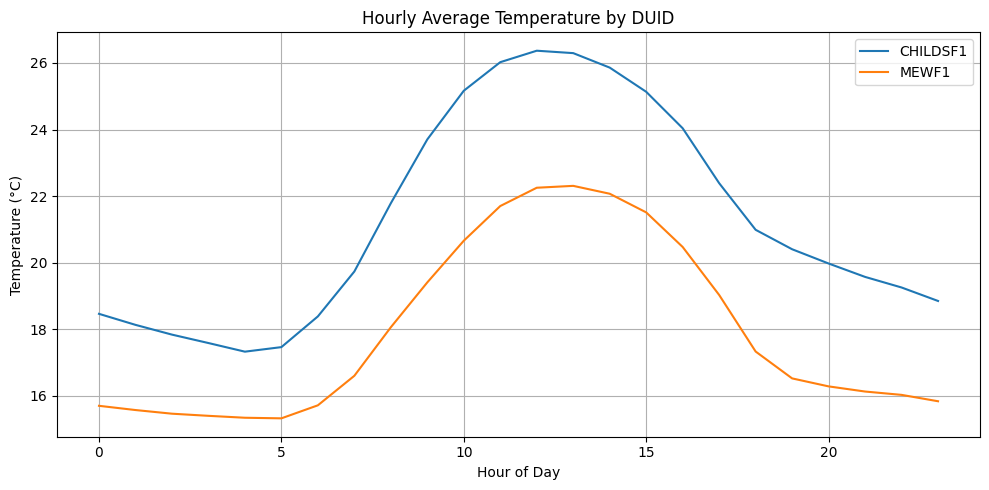

In [19]:
plt.figure(figsize=(10, 5))

for duid in ['CHILDSF1', 'MEWF1']:
    subset = filtered_df[filtered_df['DUID'] == duid]
    hourly_avg_temp = subset.groupby('hour')['temperature_2m (°C)'].mean()
    plt.plot(hourly_avg_temp.index, hourly_avg_temp.values, label=duid)

plt.title("Hourly Average Temperature by DUID")
plt.xlabel("Hour of Day")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


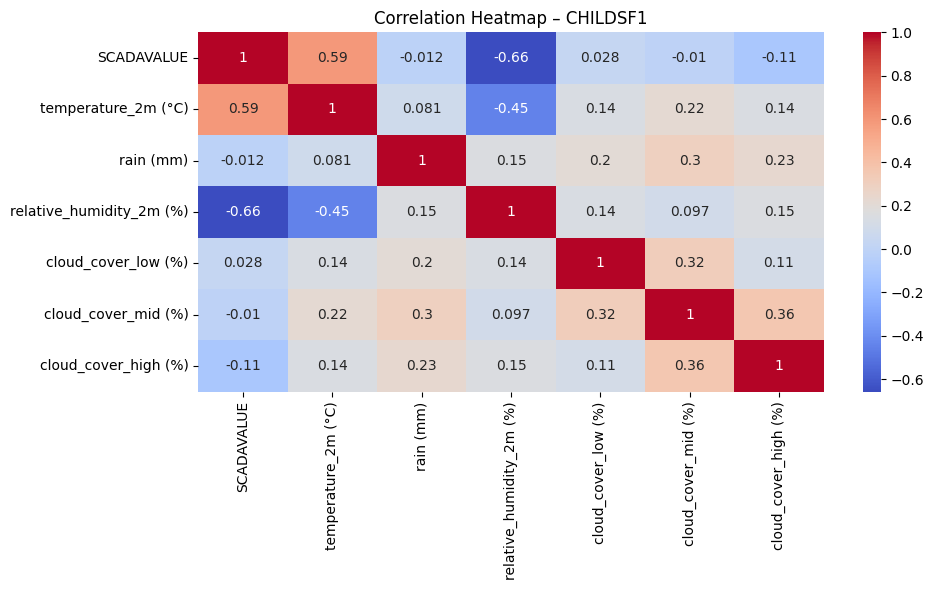

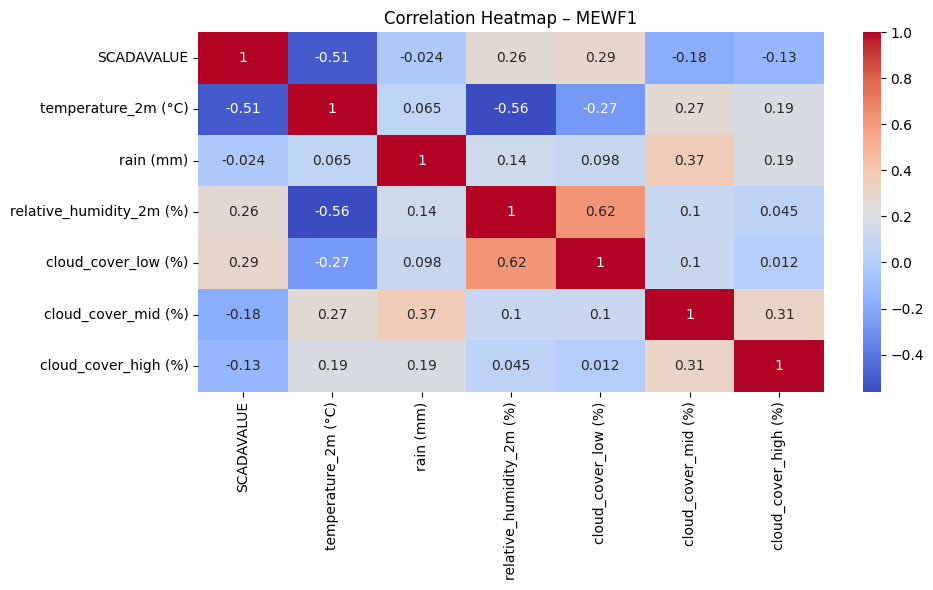

In [20]:
# Define relevant weather + target columns
weather_cols = [
    'SCADAVALUE', 'temperature_2m (°C)', 'rain (mm)',
    'relative_humidity_2m (%)',
    'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)'
]

# Loop through each DUID and plot the correlation heatmap
for duid_name in ['CHILDSF1', 'MEWF1']:
    subset = filtered_df[filtered_df['DUID'] == duid_name][weather_cols].dropna()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(subset.corr(), annot=True, cmap='coolwarm')
    plt.title(f"Correlation Heatmap – {duid_name}")
    plt.tight_layout()
    plt.show()

/var/folders/8s/d11q1jnd4p550kkfm8gcqcz80000gn/T/ipykernel_14753/1758251101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['SETTLEMENTDATE'] = pd.to_datetime(filtered_df['SETTLEMENTDATE'])
/var/folders/8s/d11q1jnd4p550kkfm8gcqcz80000gn/T/ipykernel_14753/1758251101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date_only'] = filtered_df['SETTLEMENTDATE'].dt.date


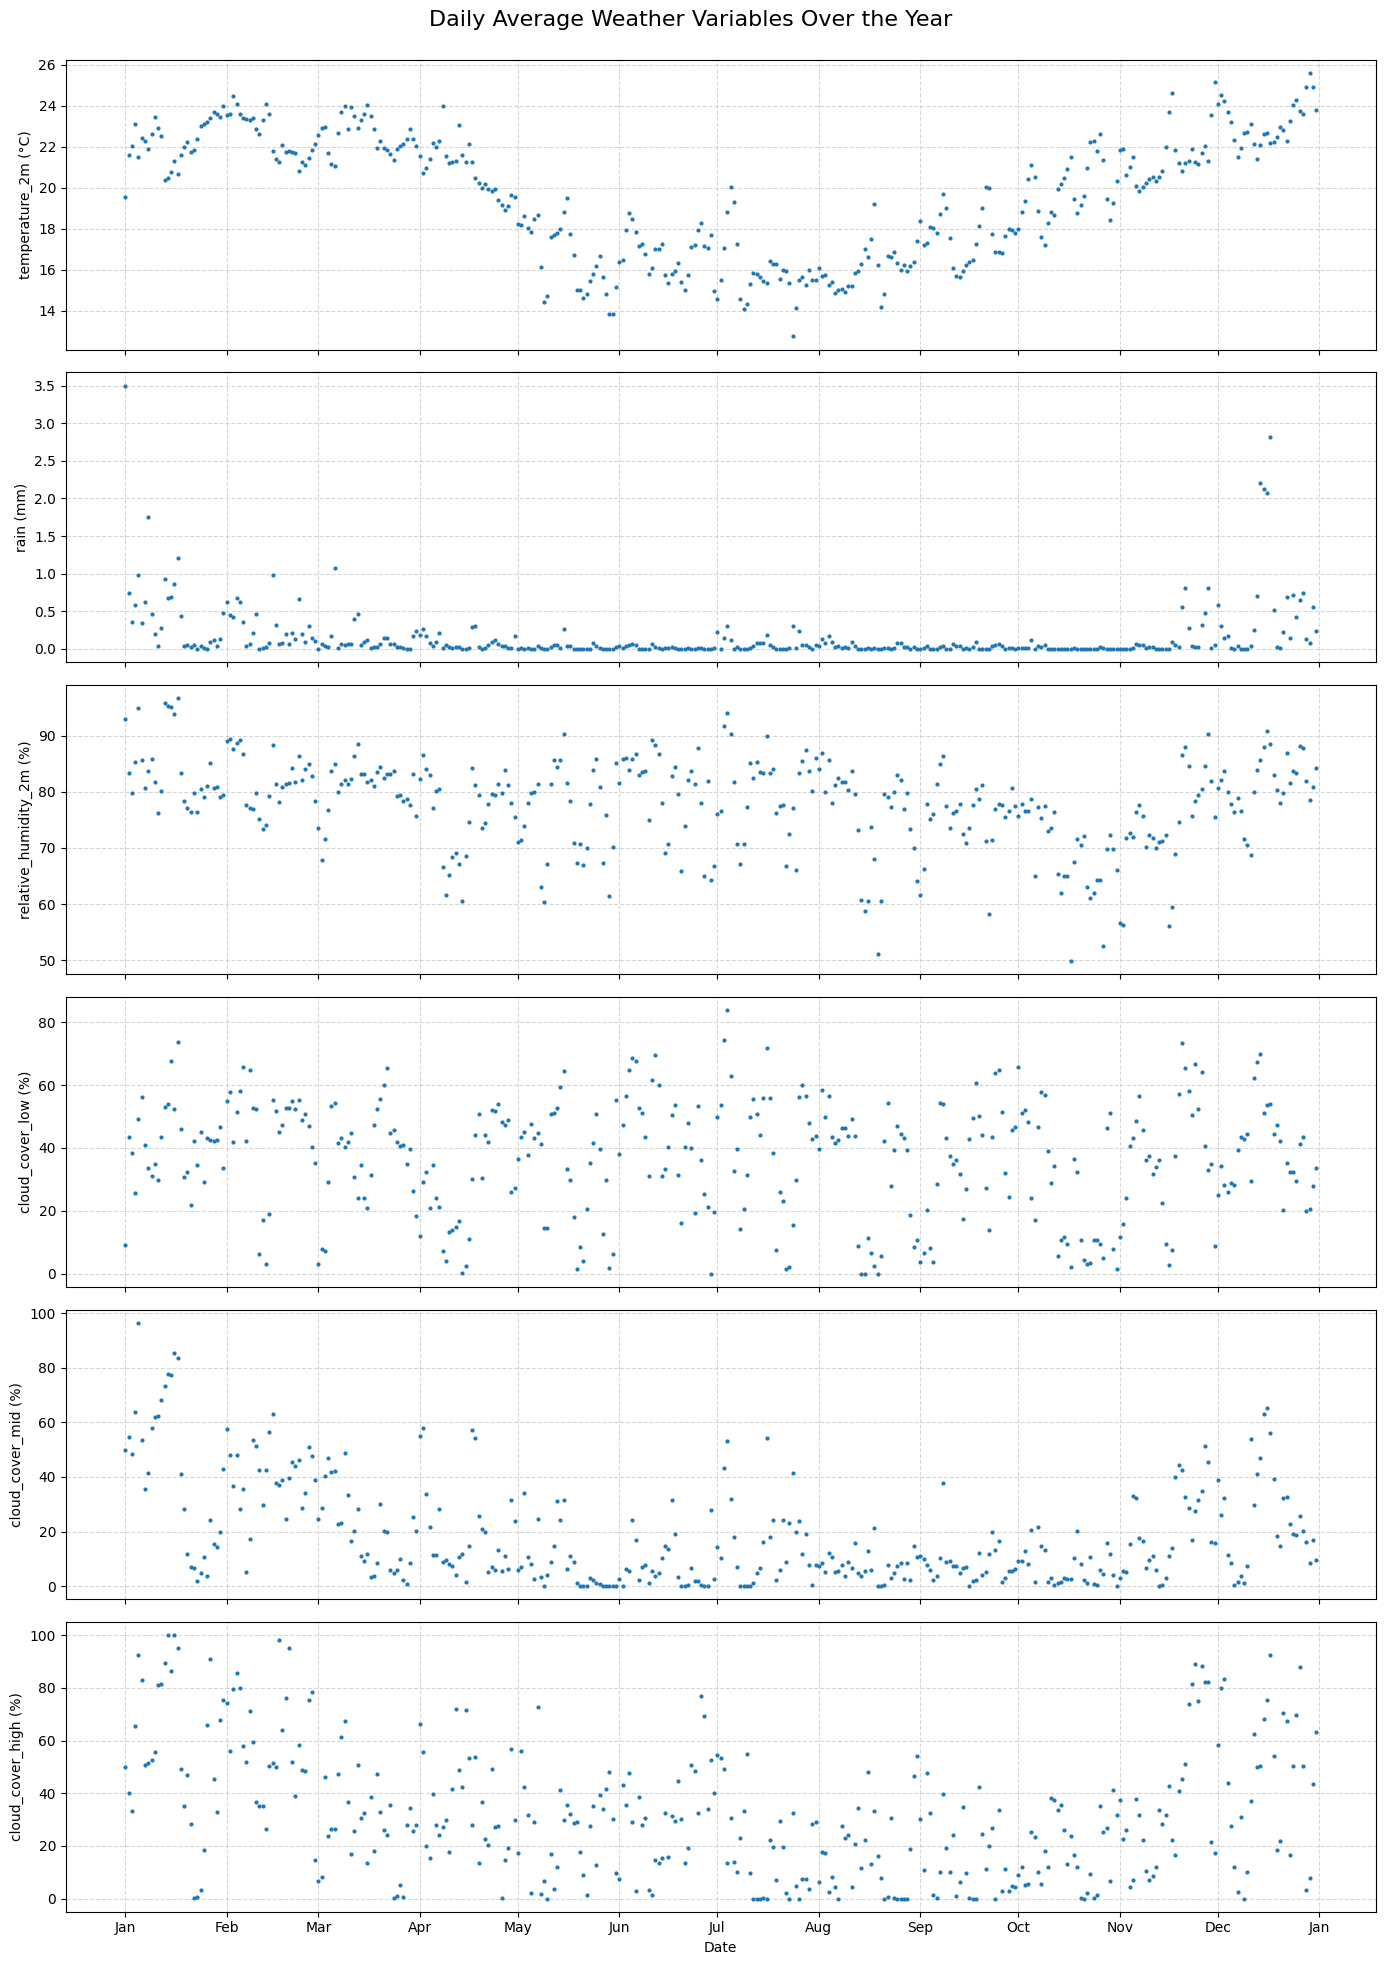

In [21]:
filtered_df['SETTLEMENTDATE'] = pd.to_datetime(filtered_df['SETTLEMENTDATE'])

# Round to day level and group
filtered_df['date_only'] = filtered_df['SETTLEMENTDATE'].dt.date
weather_cols = [
    'temperature_2m (°C)', 'rain (mm)', 'relative_humidity_2m (%)', 'cloud_cover_low (%)',
    'cloud_cover_mid (%)', 'cloud_cover_high (%)'
]

# Compute daily averages by actual date
daily_weather_avg = filtered_df.groupby('date_only')[weather_cols].mean()
daily_weather_avg.index = pd.to_datetime(daily_weather_avg.index)

fig, axs = plt.subplots(len(weather_cols), 1, figsize=(14, 20), sharex=True)

for i, col in enumerate(weather_cols):
    axs[i].plot(daily_weather_avg.index, daily_weather_avg[col], marker='o', linestyle='', markersize=2)
    axs[i].set_ylabel(col)
    axs[i].grid(True, linestyle='--', alpha=0.5)

axs[-1].set_xlabel("Date")
axs[-1].xaxis.set_major_locator(mdates.MonthLocator())
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))


fig.suptitle("Daily Average Weather Variables Over the Year", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


In [22]:
filtered_df = filtered_df.sort_values(['DUID', 'SETTLEMENTDATE']).reset_index(drop=True)
filtered_df['DELTA_SCADAVALUE'] = filtered_df.groupby('DUID')['SCADAVALUE'].diff().fillna(0)

### LSTM

In [23]:
def prepare_lstm_data(df, duid, window_size=90):
    df_duid = df[df['DUID'] == duid].copy().reset_index(drop=True)

    df_duid = pd.get_dummies(df_duid, columns=['season'], drop_first=True)
    for col in ['season_Summer', 'season_Autumn', 'season_Spring', 'season_Winter']:
        if col not in df_duid.columns:
            df_duid[col] = 0

    feature_cols = [
        'SCADAVALUE', 'hour', 'dayofweek', 'is_weekend', 'month',
        'rolling_mean_24h',
        'temperature_2m (°C)', 'rain (mm)', 'relative_humidity_2m (%)','cloud_cover_low (%)',
        'cloud_cover_mid (%)', 'cloud_cover_high (%)',
        'season_Summer', 'season_Autumn', 'season_Spring', 'season_Winter'
    ]

    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df_duid[feature_cols])
    df_scaled = pd.DataFrame(scaled_features, columns=feature_cols)

    X, y = [], []
    for i in range(window_size, len(df_scaled)):
        X.append(df_scaled.iloc[i - window_size:i].values)
        y.append(df_duid.iloc[i]['DELTA_SCADAVALUE'])

    return (
        np.array(X),
        np.array(y),
        scaler,
        df_duid.loc[window_size:, 'SETTLEMENTDATE'].values,
        df_duid.loc[window_size:, 'DELTA_SCADAVALUE'].values,
        len(feature_cols)  # return feature count
    )


X_solar, y_solar, scaler_solar, dates_solar, y_solar_actual, solar_feat_count = prepare_lstm_data(filtered_df, 'CHILDSF1')
X_wind, y_wind, scaler_wind, dates_wind, y_wind_actual, wind_feat_count = prepare_lstm_data(filtered_df, 'MEWF1')


In [24]:
def train_lstm_model(X, y, duid_name, dates, y_actual, test_hours=30*24, epochs=20, batch_size=32):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import matplotlib.pyplot as plt
    import numpy as np

    # Split into train/test
    X_train, X_test = X[:-test_hours], X[-test_hours:]
    y_train, y_test = y[:-test_hours], y[-test_hours:]
    y_actual_test = y_actual[-test_hours:]  # unscaled actual deltas
    dates_test = dates[-test_hours:]

    # LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=1
    )

    # Predict
    y_pred = model.predict(X_test).flatten()

    # Compare directly to unscaled target
    mse = mean_squared_error(y_actual_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual_test, y_pred)
    r2 = r2_score(y_actual_test, y_pred)

    print(f"\n LSTM Results for {duid_name}")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(dates_test[:500], y_actual_test[:500], label='Actual Δ Output')
    plt.plot(dates_test[:500], y_pred[:500], label='Predicted Δ Output')
    plt.title(f" LSTM: Predicted Hourly Output Differences – {duid_name}")
    plt.xlabel("Date")
    plt.ylabel("Δ Output (MW)")
    #plt.xticks(rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

Epoch 1/20
248/248 [==============================] - 16s 50ms/step - loss: 39.2127 - val_loss: 51.4791
Epoch 2/20
248/248 [==============================] - 10s 40ms/step - loss: 31.3220 - val_loss: 50.1479
Epoch 3/20
248/248 [==============================] - 10s 40ms/step - loss: 28.2283 - val_loss: 46.9119
Epoch 4/20
248/248 [==============================] - 14s 56ms/step - loss: 26.8493 - val_loss: 45.0185
Epoch 5/20
248/248 [==============================] - 14s 57ms/step - loss: 25.9591 - val_loss: 45.7886
Epoch 6/20
248/248 [==============================] - 16s 66ms/step - loss: 24.5768 - val_loss: 44.2041
Epoch 7/20
248/248 [==============================] - 17s 67ms/step - loss: 23.5640 - val_loss: 41.5297
Epoch 8/20
248/248 [==============================] - 16s 63ms/step - loss: 23.1066 - val_loss: 44.7680
Epoch 9/20
248/248 [==============================] - 13s 54ms/step - loss: 21.9963 - val_loss: 42.2705
Epoch 10/20
248/248 [==============================] - 20s 80ms/

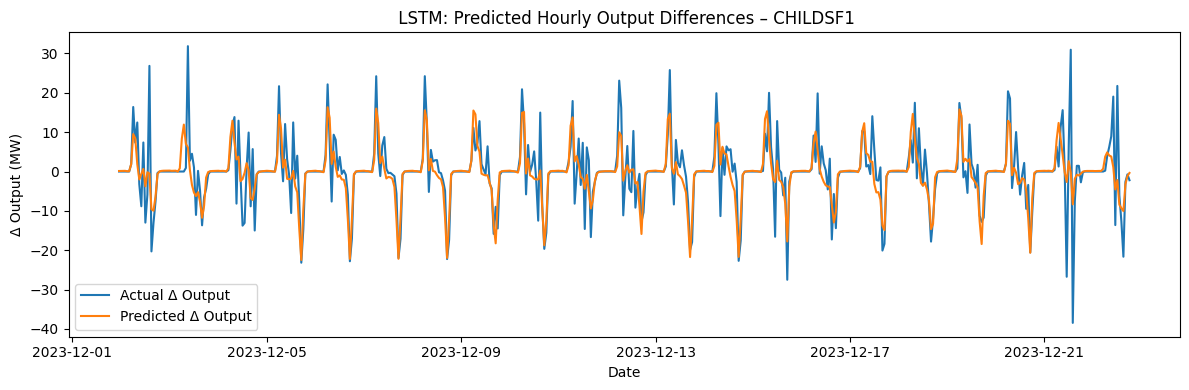

Epoch 1/20
248/248 [==============================] - 13s 40ms/step - loss: 211.8015 - val_loss: 212.1796
Epoch 2/20
248/248 [==============================] - 9s 38ms/step - loss: 198.8178 - val_loss: 213.7316
Epoch 3/20
248/248 [==============================] - 9s 36ms/step - loss: 196.7211 - val_loss: 214.4792
Epoch 4/20
248/248 [==============================] - 9s 36ms/step - loss: 195.5221 - val_loss: 216.1843
Epoch 5/20
248/248 [==============================] - 13s 53ms/step - loss: 194.0504 - val_loss: 216.1132
Epoch 6/20
248/248 [==============================] - 14s 55ms/step - loss: 193.0726 - val_loss: 211.5120
Epoch 7/20
248/248 [==============================] - 13s 52ms/step - loss: 192.1685 - val_loss: 212.5152
Epoch 8/20
248/248 [==============================] - 13s 52ms/step - loss: 190.7248 - val_loss: 212.2281
Epoch 9/20
248/248 [==============================] - 14s 56ms/step - loss: 190.3378 - val_loss: 208.2374
Epoch 10/20
248/248 [============================

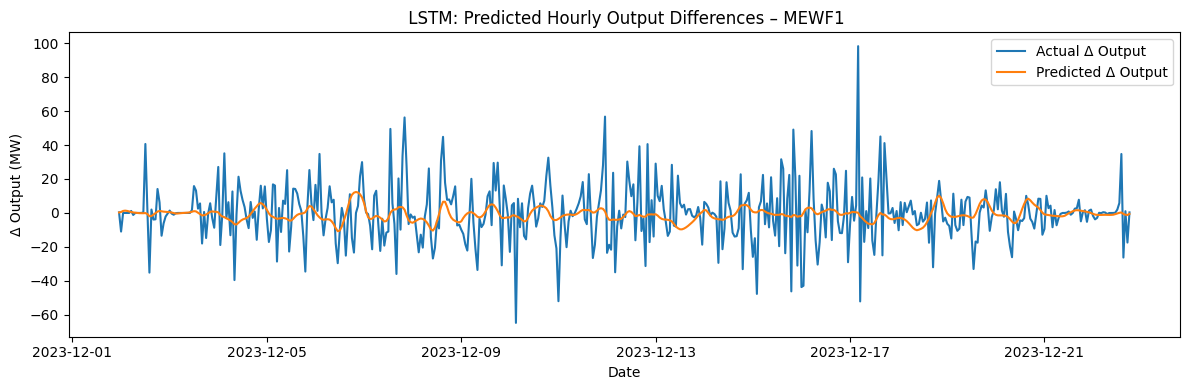

In [25]:
model_solar = train_lstm_model(X_solar, y_solar, 'CHILDSF1', dates_solar, y_solar_actual)
model_wind = train_lstm_model(X_wind, y_wind, 'MEWF1', dates_wind, y_wind_actual)

## XG Boost

Note: you may need to restart the kernel to use updated packages.

 XGBoost Results for CHILDSF1
MSE: 35.28, RMSE: 5.94, MAE: 3.41, R²: 0.512


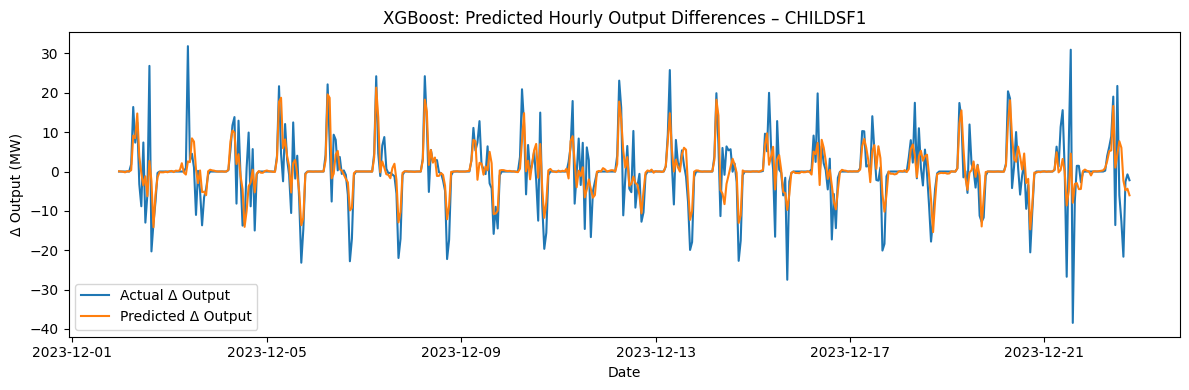


 XGBoost Results for MEWF1
MSE: 201.87, RMSE: 14.21, MAE: 10.02, R²: 0.058


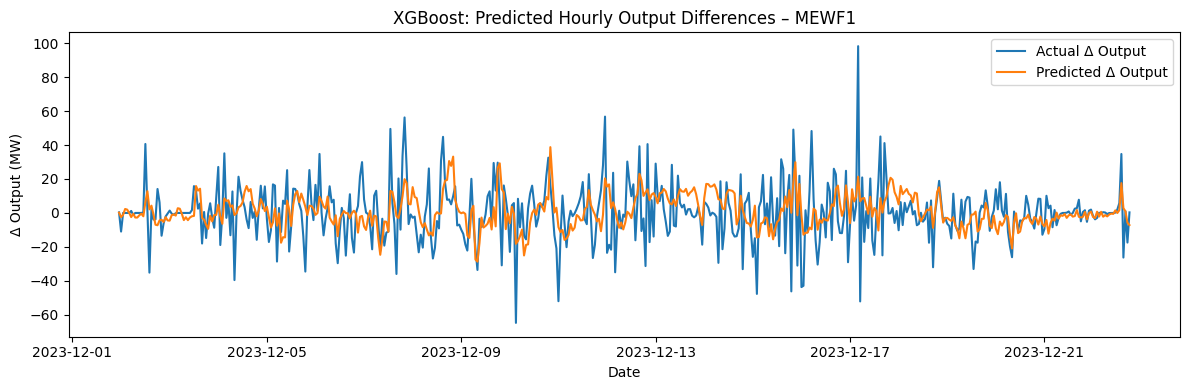

In [26]:
%pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Prepare data for XGBoost
def prepare_xgb_data(df, duid, test_hours=30*24):
    df_duid = df[df['DUID'] == duid].copy().reset_index(drop=True)
    
    # One-hot encode 'season'
    df_duid = pd.get_dummies(df_duid, columns=['season'], drop_first=True)
    for col in ['season_Summer', 'season_Autumn', 'season_Spring', 'season_Winter']:
        if col not in df_duid.columns:
            df_duid[col] = 0

    # Define features and target
    feature_cols = [
        'SCADAVALUE', 'hour', 'dayofweek', 'is_weekend', 'month',
        'rolling_mean_24h',
        'temperature_2m (°C)', 'rain (mm)', 'relative_humidity_2m (%)',
        'cloud_cover_low (%)',
        'cloud_cover_mid (%)', 'cloud_cover_high (%)',
        'season_Summer', 'season_Autumn', 'season_Spring', 'season_Winter'
    ]

    X = df_duid[feature_cols]
    y = df_duid['DELTA_SCADAVALUE']

    # Same split as LSTM (last `test_hours` for testing)
    X_train, X_test = X.iloc[:-test_hours], X.iloc[-test_hours:]
    y_train, y_test = y.iloc[:-test_hours], y.iloc[-test_hours:]

    return X_train, X_test, y_train, y_test, df_duid['SETTLEMENTDATE'].iloc[-test_hours:]

# Step 2: Apply to each DUID
X_train_solar, X_test_solar, y_train_solar, y_test_solar, dates_solar = prepare_xgb_data(filtered_df, 'CHILDSF1')
X_train_wind, X_test_wind, y_train_wind, y_test_wind, dates_wind = prepare_xgb_data(filtered_df, 'MEWF1')

# Step 3: Train and evaluate XGBoost
def train_xgb_model(X_train, X_test, y_train, y_test, dates, duid_name):
    xg_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.7,
        learning_rate=0.05,
        max_depth=10,
        n_estimators=300
    )

    xg_reg.fit(X_train, y_train)
    y_pred = xg_reg.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n XGBoost Results for {duid_name}")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(dates[:500], y_test[:500].values, label='Actual Δ Output')
    plt.plot(dates[:500], y_pred[:500], label='Predicted Δ Output')
    plt.title(f"XGBoost: Predicted Hourly Output Differences – {duid_name}")
    plt.xlabel("Date")
    plt.ylabel("Δ Output (MW)")
    plt.xticks(rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return xg_reg

# Step 4: Run both models
xgb_model_solar = train_xgb_model(X_train_solar, X_test_solar, y_train_solar, y_test_solar, dates_solar, 'CHILDSF1')
xgb_model_wind = train_xgb_model(X_train_wind, X_test_wind, y_train_wind, y_test_wind, dates_wind, 'MEWF1')


## Random Forest


 Random Forest Results for CHILDSF1
MSE: 30.84, RMSE: 5.55, MAE: 3.12, R²: 0.573


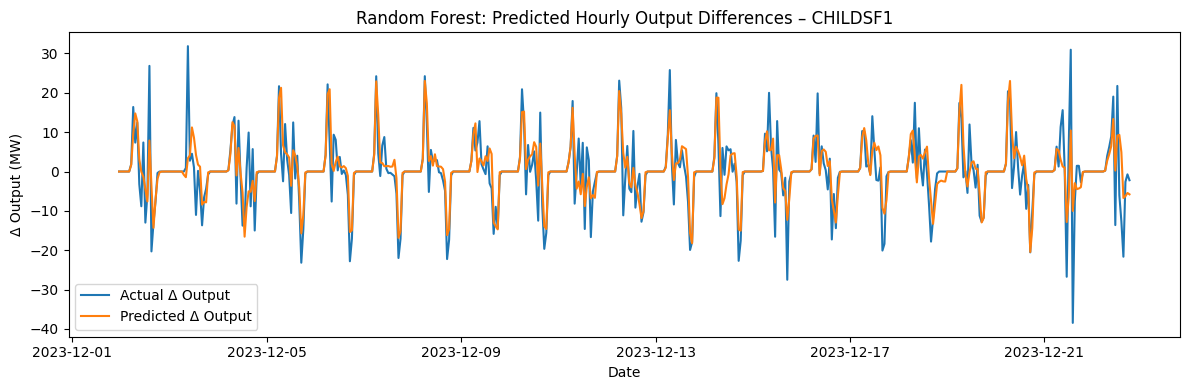


 Random Forest Results for MEWF1
MSE: 201.25, RMSE: 14.19, MAE: 9.80, R²: 0.061


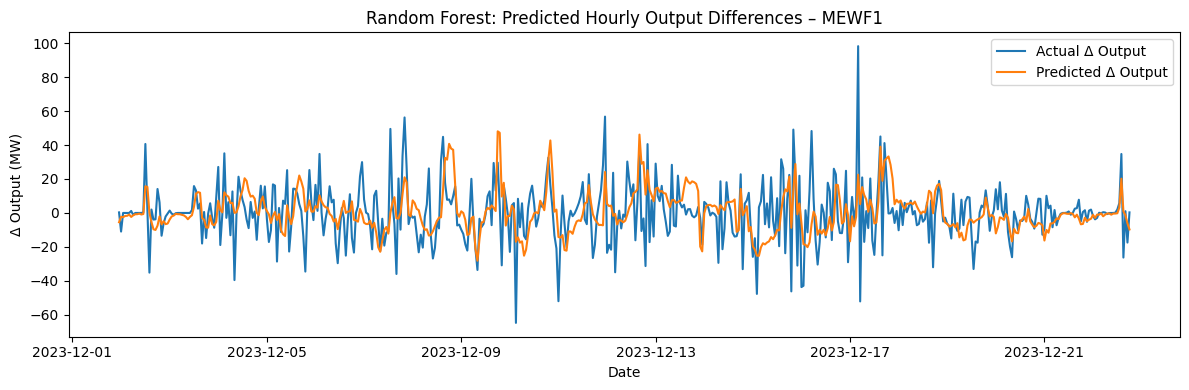

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Prepare data
def prepare_rf_data(df, duid, test_hours=30*24):
    df_duid = df[df['DUID'] == duid].copy().reset_index(drop=True)

    df_duid = pd.get_dummies(df_duid, columns=['season'], drop_first=True)
    for col in ['season_Summer', 'season_Autumn', 'season_Spring', 'season_Winter']:
        if col not in df_duid.columns:
            df_duid[col] = 0

    feature_cols = [
        'SCADAVALUE', 'hour', 'dayofweek', 'is_weekend', 'month',
        'rolling_mean_24h',
        'temperature_2m (°C)', 'rain (mm)', 'relative_humidity_2m (%)',
        'precipitation (mm)', 'cloud_cover_low (%)',
        'cloud_cover_mid (%)', 'cloud_cover_high (%)',
        'season_Summer', 'season_Autumn', 'season_Spring', 'season_Winter'
    ]

    X = df_duid[feature_cols]
    y = df_duid['DELTA_SCADAVALUE']

    # Consistent split
    X_train, X_test = X.iloc[:-test_hours], X.iloc[-test_hours:]
    y_train, y_test = y.iloc[:-test_hours], y.iloc[-test_hours:]
    dates = df_duid['SETTLEMENTDATE'].iloc[-test_hours:]

    return X_train, X_test, y_train, y_test, dates

# Step 2: Apply to each generator
X_train_solar, X_test_solar, y_train_solar, y_test_solar, dates_solar = prepare_rf_data(filtered_df, 'CHILDSF1')
X_train_wind, X_test_wind, y_train_wind, y_test_wind, dates_wind = prepare_rf_data(filtered_df, 'MEWF1')

# Step 3: Train and evaluate
def train_rf_model(X_train, X_test, y_train, y_test, dates, duid_name):
    rf_reg = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Random Forest Results for {duid_name}")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(dates[:500], y_test.values[:500], label='Actual Δ Output')
    plt.plot(dates[:500], y_pred[:500], label='Predicted Δ Output')
    plt.title(f"Random Forest: Predicted Hourly Output Differences – {duid_name}")
    plt.xlabel("Date")
    plt.ylabel("Δ Output (MW)")
    #plt.xticks(rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rf_reg

# Step 4: Run models
rf_model_solar = train_rf_model(X_train_solar, X_test_solar, y_train_solar, y_test_solar, dates_solar, 'CHILDSF1')
rf_model_wind = train_rf_model(X_train_wind, X_test_wind, y_train_wind, y_test_wind, dates_wind, 'MEWF1')


## Arima

/Users/pouya_kp/Desktop/IFN695/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pouya_kp/Desktop/IFN695/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pouya_kp/Desktop/IFN695/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 ARIMA Results for CHILDSF1
MSE: 63.98, RMSE: 8.00, MAE: 4.71, R²: 0.115


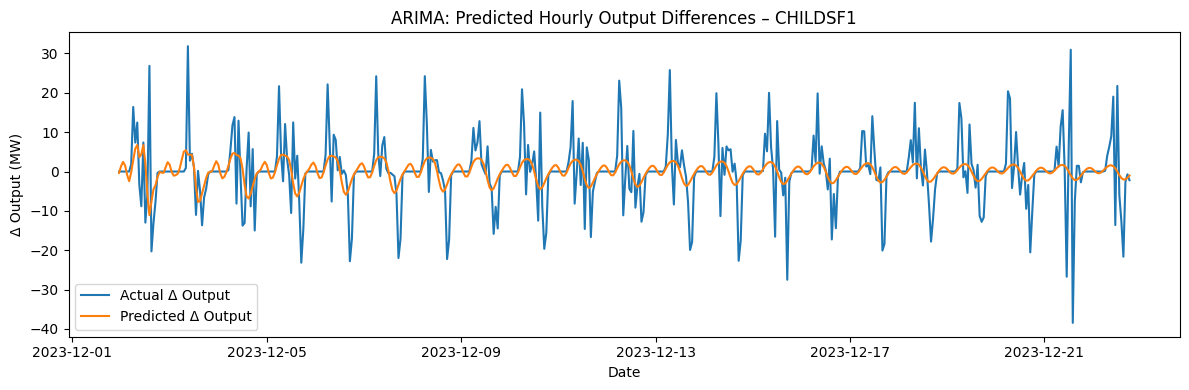

/Users/pouya_kp/Desktop/IFN695/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 ARIMA Results for MEWF1
MSE: 215.07, RMSE: 14.67, MAE: 9.39, R²: -0.003


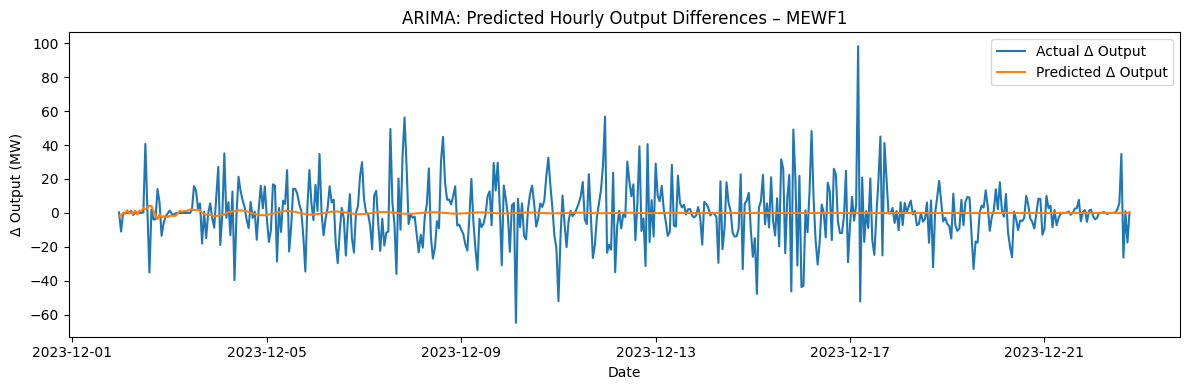

In [28]:
#Define ARIMA training and evaluation function
def train_arima_model(df, duid, test_hours=30*24, order=(24, 0, 12)):
    # Filter by DUID and reset index
    df_duid = df[df['DUID'] == duid].copy().reset_index(drop=True)

    # Drop NaNs
    ts = df_duid['DELTA_SCADAVALUE'].dropna()

    # Train/test split
    train, test = ts[:-test_hours], ts[-test_hours:]
    dates = df_duid['SETTLEMENTDATE'].iloc[-test_hours:]

    # Fit model
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
    except Exception as e:
        print(f" ARIMA model failed for {duid}: {e}")
        return None, None

    # Evaluation metrics
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"\n ARIMA Results for {duid}")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 4))
    plt.plot(dates[:500], test.values[:500], label='Actual Δ Output')
    plt.plot(dates[:500], forecast[:500], label='Predicted Δ Output')
    plt.title(f"ARIMA: Predicted Hourly Output Differences – {duid}")
    plt.xlabel("Date")
    plt.ylabel("Δ Output (MW)")
    #plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model_fit, forecast

#Apply to DUIDs
arima_model_solar, forecast_solar = train_arima_model(filtered_df, 'CHILDSF1')
arima_model_wind, forecast_wind = train_arima_model(filtered_df, 'MEWF1')


 XGBoost SCADAVALUE Prediction (MEWF1):
RMSE = 7.71, MAE = 5.37, R² = 0.977


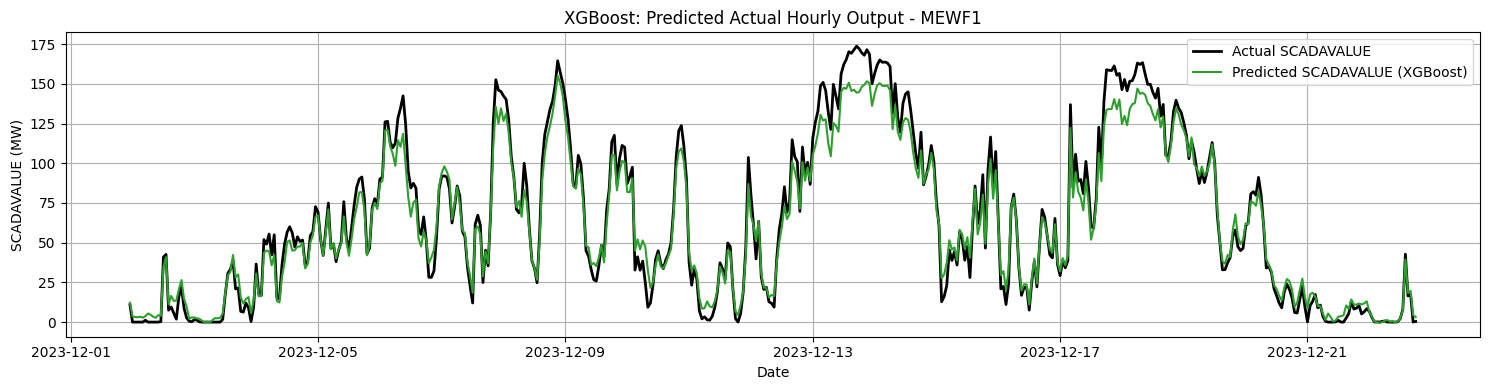

In [31]:


#Parameters
test_hours = 30 * 24  # 720 hours = last 30 days

#Filter and preprocess MEWF1 data 
df_wind = filtered_df[filtered_df['DUID'] == 'MEWF1'].copy().reset_index(drop=True)

# One-hot encode season
df_wind = pd.get_dummies(df_wind, columns=['season'], drop_first=True)
for col in ['season_Summer', 'season_Autumn', 'season_Spring', 'season_Winter']:
    if col not in df_wind.columns:
        df_wind[col] = 0

# Feature columns
feature_cols = [
    'SCADAVALUE', 'hour', 'dayofweek', 'is_weekend', 'month',
    'rolling_mean_24h', 'temperature_2m (°C)', 'rain (mm)', 'relative_humidity_2m (%)',
    'precipitation (mm)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
    'season_Summer', 'season_Autumn', 'season_Spring', 'season_Winter'
]

# Define X and y
X = df_wind[feature_cols]
y = df_wind['SCADAVALUE']

# Train/test split
X_train = X.iloc[:-test_hours]
X_test = X.iloc[-test_hours:]
y_train = y.iloc[:-test_hours]
y_test = y.iloc[-test_hours:]
dates_test = df_wind['SETTLEMENTDATE'].iloc[-test_hours:].reset_index(drop=True)

#Train model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f" XGBoost SCADAVALUE Prediction (MEWF1):")
print(f"RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.3f}")

#Plot: Actual vs Predicted SCADAVALUE
plt.figure(figsize=(15, 4))
plt.plot(dates_test[:500], y_test.reset_index(drop=True)[:500], label='Actual SCADAVALUE', color='black', linewidth=2)
plt.plot(dates_test[:500], y_pred[:500], label='Predicted SCADAVALUE (XGBoost)', color='tab:green')
plt.title("XGBoost: Predicted Actual Hourly Output - MEWF1")
plt.xlabel("Date")
plt.ylabel("SCADAVALUE (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Solar Variance (CHILDSF1): 232.28
Wind Variance  (MEWF1):   2324.91


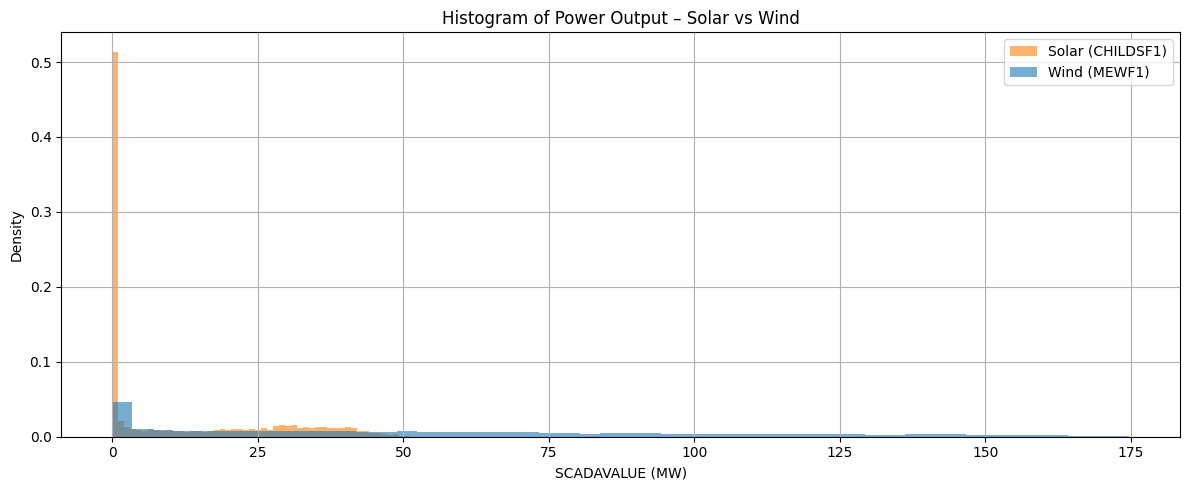

In [30]:
df_solar = filtered_df[filtered_df['DUID'] == 'CHILDSF1'].copy()
df_wind = filtered_df[filtered_df['DUID'] == 'MEWF1'].copy()
solar_output = df_solar['SCADAVALUE']
wind_output = df_wind['SCADAVALUE']

solar_var = solar_output.var()
wind_var = wind_output.var()

print(f"Solar Variance (CHILDSF1): {solar_var:.2f}")
print(f"Wind Variance  (MEWF1):   {wind_var:.2f}")


plt.figure(figsize=(12, 5))

plt.hist(solar_output, bins=50, alpha=0.6, label='Solar (CHILDSF1)', color='tab:orange', density=True)
plt.hist(wind_output, bins=50, alpha=0.6, label='Wind (MEWF1)', color='tab:blue', density=True)

plt.title('Histogram of Power Output – Solar vs Wind')
plt.xlabel('SCADAVALUE (MW)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
